In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import torch
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from utils.vis import *
from model import PoseModel
from transform import *
from dataset import PlanktonDataset
from visualdl import LogWriter, LogReader

%matplotlib inline

In [2]:
img_dir = '/data5/Plankton_wi18/rawcolor_db/images'
csv_filename = 'data/data_{}.csv'

phases = ['train', 'valid', 'test']

# dataset_mean, dataset_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
normalize = Normalize([0.5, 0.5, 0.5], [1, 1, 1])

batch_size = 16

input_size = (384, 384)

_GPU = 1

In [3]:
data_transform = {
    'train': transforms.Compose([
        Rescale(input_size),
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        ToTensor(),
        normalize
    ]),
    'valid': transforms.Compose([
        Rescale(input_size),
        ToTensor(),
        normalize
    ]),
    'test': transforms.Compose([
        Rescale(input_size),
        ToTensor(),
        normalize
    ])
}

datasets = {x: PlanktonDataset(csv_file=csv_filename.format(x),
                               img_dir=img_dir,
                               transform=data_transform[x])
            for x in phases}

dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size,
                             shuffle=True, num_workers=4)
               for x in phases}

dataset_sizes = {x: len(datasets[x]) for x in phases}

use_gpu = torch.cuda.is_available()

In [4]:
model = PoseModel()
model = nn.DataParallel(model)
model = model.cuda()

In [5]:
checkpoints = torch.load('model_checkpoints/model_best.pth.tar')
model.load_state_dict(checkpoints['state_dict'])

[('Appendicularia (class)', 'Hydromedusae', 'Amphipoda', 'Cyclopoida', 'Polychaeta (class)', 'Calanoida', 'Calanoida', 'Calanoida', 'Euphausiacea', 'Polychaeta (class)', 'Calanoida', 'Cyclopoida', 'Cyclopoida', 'Euphausiacea', 'Decapoda', 'Euphausiacea'), ('Appendicularia (class)', 'Hydromedusae (order)', 'Gammaridae', 'Poecilostomatoida', 'Polychaeta (class)', 'Pontellidae', 'Calanoida (order)', 'Calanoida (order)', 'Euphausiidae', 'Polychaeta (class)', 'Calanidae', 'Oithonidae', 'Oithonidae', 'Euphausiidae', 'Brachyura', 'Euphausiidae'), ('Appendicularia (class)', 'Hydromedusae (order)', 'Gammaridae (family)', 'Poecilostomatoida (family)', 'Polychaeta (class)', 'Pontellidae (family)', 'Calanoida (order)', 'Calanoida (order)', 'Euphausiidae (family)', 'Polychaeta (class)', 'Calanus', 'Oithonidae (family)', 'Oithonidae (family)', 'Euphausiidae (family)', 'Brachyura (family)', 'Euphausiidae (family)'), ('20170126_001', '20170224_008', '20170214_004', '20170224_005', '20170303_002', '201

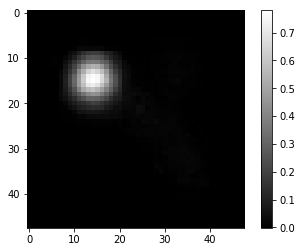

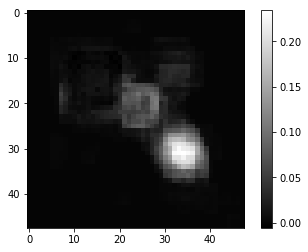

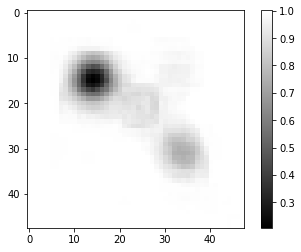

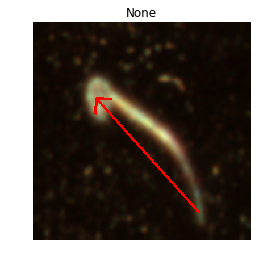

In [6]:
for data in dataloaders['test']:
    model.eval()
    inputs, target, coordinates, classes = data['image'], data['target_map'], data['coordinates'], data['cls']
    print(classes)
    
    if use_gpu:
        inputs = Variable(inputs.cuda())
        target = Variable(target.cuda())
    else:
        inputs, target = Variable(inputs), Variable(target)
    
    outputs = model(inputs)
    pred_maps = outputs.cpu().data[0].numpy()
    for pred_map in pred_maps:
        plt.figure()
        plt.imshow(pred_map, cmap='gray')
        plt.colorbar()
    
    data0 = normalize.recover(data)
    images = data0['image']
    
    plt.figure()
    show_arrow(images[0], coordinates[0], None)

    break

In [7]:
model

DataParallel (
  (module): PoseModel (
    (pretrained): Sequential (
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU (inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU (inplace)
      (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU (inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU (inplace)
      (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU (inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU (inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU (inplace)
      (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(

In [8]:
rd = LogReader('/data3/ludi/plankton_wi17/pose/poseprediction_torch/log')

In [18]:
with rd.mode('train'):
    loss = rd.scalar('scalars/train_loss')
len(loss.records())

52861